In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch

In [ ]:
from modules.networks_dit import DiT
from modules.networks_unet import UNetModel

unet = UNetModel(
    in_channels=3,
    out_channels=3,
    channels=128,
    channel_multipliers=[1, 2, 2, 2],
    attention_levels=[1, 2],
    n_heads=4,
    num_classes=10,
    n_res_block=2,
)

print(sum(p.numel() for p in unet.parameters() if p.requires_grad))

dit = DiT(
    input_size=32,
    patch_size=2,
    in_channels=3,
    dim=512,
    depth=8,
    num_heads=8,
    num_classes=10
)

print(sum(p.numel() for p in dit.parameters() if p.requires_grad))

In [6]:
from modules.edm2.networks_karras_unet import UNet

net = UNet(
    img_resolution=32,
    img_channels=4,
    label_dim=64
)
x = torch.randn(1, 4, 32, 32)
t = torch.rand((1,))
y = torch.tensor([0])
net(x, t, y)

IndexError: tuple index out of range

In [ ]:
from torchvision.datasets import ImageNet

ds = ImageNet("/mnt/g/ImageNet")

In [ ]:
ds[0]

In [ ]:
from random import randint
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(256),
    T.ToTensor()
])

data = ds[randint(0, len(ds))]
display(transform(data[0]))

In [ ]:
from diffusers.models import AutoencoderKL
from random import randint
import torch


data = ds[randint(0, len(ds))]
x = transform(data[0]).unsqueeze(0)
x = 2 * x - 1
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")
with torch.autocast("cuda", dtype=torch.bfloat16):
    with torch.no_grad():
        x_ = vae.encode(x).latent_dist.sample().mul_(0.13025)
        print(x_.shape)
        x_ = vae.decode(x_ / 0.13025).sample

In [ ]:
from torchvision.transforms.functional import to_pil_image
def unnormalize(x):
    x = x.clip(-1, 1)
    return (x + 1) / 2
display(to_pil_image(unnormalize(x)[0]))
display(to_pil_image(unnormalize(x_)[0]))

In [36]:
from torchvision.datasets import ImageNet
from torch.utils.data import Dataset
import torch
from pathlib import Path
from PIL import Image


class LatentImageNetDataset(Dataset):
    def __init__(self, root):
        self.imagenet_ds = ImageNet(root, split="train")
        imgs = self.imagenet_ds.imgs
        latent_paths = [Path(img[0].replace("train", "latent_train")) for img in imgs]
        latent_paths = [str(p.parent / (p.stem + ".pth")) for p in latent_paths]
        self.ds = [(img[0], l_path, img[1]) for img, l_path in zip(imgs, latent_paths)]
    
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        path, latent_path, label = self.ds[idx]
        img = Image.open(path)
        latent = torch.load(latent_path)
        return {"img": img, "latent": latent, "label": label}

In [37]:
ds = LatentImageNetDataset("/mnt/g/ImageNet")

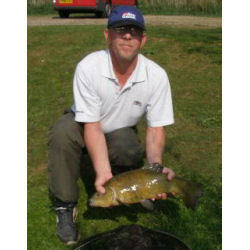

tensor([[[ 2.4096,  2.4259,  2.5562,  ...,  2.8655,  2.3771,  2.5724],
         [ 1.9375,  2.1980,  1.9130,  ...,  2.2794,  2.1654,  2.1166],
         [ 2.2142,  2.0677,  2.1654,  ...,  2.8167,  2.0596,  2.3933],
         ...,
         [ 2.1980,  2.1328,  2.4096,  ...,  2.6050,  2.0759,  2.3771],
         [ 2.1817,  2.1980,  2.2957,  ...,  2.3282,  1.9700,  2.5236],
         [ 2.4259,  2.4747,  2.7841,  ...,  2.8655,  2.4585,  2.3608]],

        [[-0.4701, -0.0712, -0.1211,  ...,  0.0109, -0.1740,  0.5780],
         [-0.3317,  0.3765, -0.2727,  ..., -0.0753,  0.3195,  0.4070],
         [-0.0435,  0.3602,  0.4599,  ...,  0.6716,  0.1801,  0.7123],
         ...,
         [-0.0359,  0.3500,  0.0256,  ...,  0.1954,  0.2554,  0.7530],
         [ 0.0112,  0.1414, -0.0702,  ...,  0.0131,  0.0562,  0.6960],
         [ 0.6431,  0.7856,  0.5373,  ...,  0.8995,  0.6146,  0.5861]],

        [[ 1.1804, -0.1231,  0.0186,  ...,  0.0753, -0.1343,  0.9362],
         [ 0.3439,  0.9199,  0.5454,  ...,  0

0

In [40]:
for v in ds[0].values():
    display(v)

In [5]:
def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [14]:
betas = sigmoid_beta_schedule(1000)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
snr = alphas_cumprod / (1 - alphas_cumprod)

In [12]:
from torchvision.datasets import ImageFolder

ds = ImageFolder("/mnt/g/artbench-10-imagefolder-split/train")

In [14]:
display(ds[0])

(<PIL.Image.Image image mode=RGB size=256x256>, 0)